# Single sample intracellular signalling network inference

In this notebook we showcase how to use the advanced CARNIVAL implementation available in CORNETO. This implementation extends the capabilities of the original CARNIVAL method by enabling advanced modelling and injection of knowledge for hypothesis generation. We will use a dataset consisting of 6 samples of hepatic stellate cells (HSC) where three of them were activated by the cytokine Transforming growth factor (TGF-β). 

In the first part, we will show how to estimate Transcription Factor activities from gene expression data, following the [Decoupler tutorial](https://decoupler-py.readthedocs.io/en/latest/notebooks/bulk.html) for functional analysis. Then, we will use the CARNIVAL method available in CORNETO to infer a network from TFs to receptors, assuming that we don't really know which treatment was used.

In [1]:
# --- Saezlab tools --- 
# https://decoupler-py.readthedocs.io/
import decoupler as dc
# https://omnipathdb.org/
import omnipath as op
# https://saezlab.github.io/
import corneto as cn


# --- Additional libs --- 

# Pydeseq for differential expression analysis
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

# Additional packages
import pandas as pd
import numpy as np
import urllib.request
import gzip
import shutil
import tempfile
import os

In [2]:
max_time = 300
seed = 0

In [3]:
# We need to download the dataset, available at GEO GSE151251
url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE151251&format=file&file=GSE151251%5FHSCs%5FCtrl%2Evs%2EHSCs%5FTGFb%2Ecounts%2Etsv%2Egz'

adata = None 
with tempfile.TemporaryDirectory() as tmpdirname:
    # Path for the gzipped file in the temp folder
    gz_file_path = os.path.join(tmpdirname, 'counts.txt.gz')
    
    # Download the file
    with urllib.request.urlopen(url) as response:
        with open(gz_file_path, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
    
    # Decompress the file
    decompressed_file_path = gz_file_path[:-3]  # Removing '.gz' extension
    with gzip.open(gz_file_path, 'rb') as f_in:
        with open(decompressed_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    adata = pd.read_csv(decompressed_file_path, index_col=2, sep='\t').iloc[:, 5:].T

adata

GeneName,DDX11L1,WASH7P,MIR6859-1,MIR1302-11,MIR1302-9,FAM138A,OR4G4P,OR4G11P,OR4F5,RP11-34P13.7,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
25_HSCs-Ctrl1,0,9,10,1,0,0,0,0,0,33,...,93192,342,476,493,54466,17184,1302,54099,258,475
26_HSCs-Ctrl2,0,12,14,0,0,0,0,0,0,66,...,114914,355,388,436,64698,21106,1492,62679,253,396
27_HSCs-Ctrl3,0,14,10,0,0,0,0,0,0,52,...,155365,377,438,480,85650,31860,2033,89559,282,448
31_HSCs-TGFb1,0,11,16,0,0,0,0,0,0,54,...,110866,373,441,481,60325,19496,1447,66283,172,341
32_HSCs-TGFb2,0,5,8,0,0,0,0,0,0,44,...,45488,239,331,343,27442,9054,624,27535,96,216
33_HSCs-TGFb3,0,12,5,0,0,0,0,0,0,32,...,70704,344,453,497,45443,13796,1077,43415,192,243


## Data preprocessing

We will use AnnData and PyDeseq2 to pre-process the data and compute differential expression between control and tretament

In [4]:
from anndata import AnnData

adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

C:\Users\pablo\miniconda3\envs\corneto-dev-mini\Lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\pablo\miniconda3\envs\corneto-dev-mini\Lib\site-packages\anndata\utils.py:261: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


AnnData object with n_obs × n_vars = 6 × 64253

In [5]:
# Process treatment information
adata.obs['condition'] = ['control' if '-Ctrl' in sample_id else 'treatment' for sample_id in adata.obs.index]

# Process sample information
adata.obs['sample_id'] = [sample_id.split('_')[0] for sample_id in adata.obs.index]

# Visualize metadata
adata.obs

,condition,sample_id
25_HSCs-Ctrl1,control,25
26_HSCs-Ctrl2,control,26
27_HSCs-Ctrl3,control,27
31_HSCs-TGFb1,treatment,31
32_HSCs-TGFb2,treatment,32
33_HSCs-TGFb3,treatment,33


In [6]:
# Obtain genes that pass the thresholds
genes = dc.filter_by_expr(adata, group='condition', min_count=10, min_total_count=15, large_n=1, min_prop=1)

# Filter by these genes
adata = adata[:, genes].copy()
adata

AnnData object with n_obs × n_vars = 6 × 19713
    obs: 'condition', 'sample_id'

In [7]:
# Estimation of differential expression

inference = DefaultInference()
dds = DeseqDataSet(
    adata=adata,
    design_factors='condition',
    refit_cooks=True,
    inference=inference,
)

In [8]:
# Compute LFCs
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 11.68 seconds.

Fitting dispersion trend curve...
... done in 1.20 seconds.

Fitting MAP dispersions...
... done in 10.25 seconds.

Fitting LFCs...
... done in 5.81 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



In [9]:
stat_res = DeseqStats(
    dds,
    contrast=["condition", 'treatment', 'control'],
    inference=inference
)

stat_res.summary()

Running Wald tests...
... done in 2.97 seconds.



Log2 fold change & Wald test p-value: condition treatment vs control
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
GeneName                                                                   
WASH7P           10.349784       -0.011129  0.651922 -0.017071  0.986380   
MIR6859-1        10.114621        0.000625  0.657581  0.000950  0.999242   
RP11-34P13.7     45.731312        0.078209  0.324512  0.241005  0.809551   
RP11-34P13.8     29.498379       -0.065178  0.393711 -0.165549  0.868512   
CICP27          106.032659        0.150594  0.223024  0.675239  0.499524   
...                    ...             ...       ...       ...       ...   
MT-ND6        17914.984474       -0.435304  0.278796 -1.561372  0.118436   
MT-TE          1281.293477       -0.332495  0.288073 -1.154204  0.248416   
MT-CYB        54955.449372       -0.313285  0.286900 -1.091966  0.274848   
MT-TT           204.692221       -0.485882  0.220606 -2.202488  0.027631   
MT-TP           345

In [10]:
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
WASH7P,10.349784,-0.011129,0.651922,-0.017071,0.986380,0.991409
MIR6859-1,10.114621,0.000625,0.657581,0.000950,0.999242,0.999520
RP11-34P13.7,45.731312,0.078209,0.324512,0.241005,0.809551,0.877381
RP11-34P13.8,29.498379,-0.065178,0.393711,-0.165549,0.868512,0.917121
CICP27,106.032659,0.150594,0.223024,0.675239,0.499524,0.637374
...,...,...,...,...,...,...
MT-ND6,17914.984474,-0.435304,0.278796,-1.561372,0.118436,0.211001
MT-TE,1281.293477,-0.332495,0.288073,-1.154204,0.248416,0.380057
MT-CYB,54955.449372,-0.313285,0.286900,-1.091966,0.274848,0.411271


## Prior knowledge with Decoupler and Omnipath

In [11]:
# Retrieve CollecTRI gene regulatory network (through Omnipath)
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...
...,...,...,...,...
43173,NFKB,hsa-miR-143-3p,1,19472311
43174,AP1,hsa-miR-206,1,19721712
43175,NFKB,hsa-miR-21-5p,1,20813833;22387281
43176,NFKB,hsa-miR-224-5p,1,23474441;23988648


In [12]:
mat = results_df[['stat']].T.rename(index={'stat': 'treatment.vs.control'})
mat

GeneName,WASH7P,MIR6859-1,RP11-34P13.7,RP11-34P13.8,CICP27,FO538757.2,AP006222.2,RP4-669L17.10,MTND1P23,MTND2P28,...,MT-ND4,MT-TH,MT-TS2,MT-TL2,MT-ND5,MT-ND6,MT-TE,MT-CYB,MT-TT,MT-TP
treatment.vs.control,-0.017071,0.00095,0.241005,-0.165549,0.675239,-1.645412,2.041302,-0.376843,-1.994386,-0.498507,...,-1.435973,0.754913,1.139002,1.167032,-1.242582,-1.561372,-1.154204,-1.091966,-2.202488,-2.848936


In [13]:
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri, verbose=True)
tf_acts

Running ulm on mat with 1 samples and 19713 targets for 655 sources.


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID1A,ARID3A,ARID3B,ARID4A,...,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF804A,ZNF91,ZXDC
treatment.vs.control,-2.181499,-1.556123,-1.824668,-1.983679,-2.673171,0.235021,-3.93546,0.870591,1.649556,-0.612672,...,-0.063138,2.123082,1.887668,-1.141122,1.571889,1.277879,-0.116911,1.92635,0.91651,-2.744753


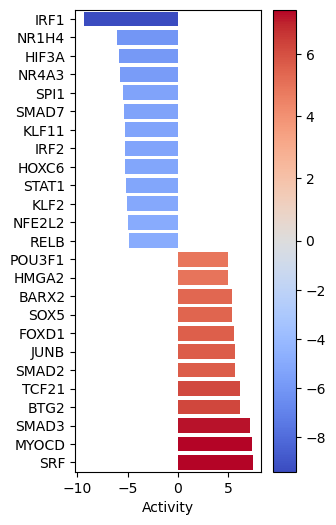

In [14]:
dc.plot_barplot(
    acts=tf_acts,
    contrast='treatment.vs.control',
    top=25,
    vertical=True,
    figsize=(3, 6)
)

In [15]:
# We obtain ligand-receptor interactions from Omnipath, and we keep only the receptors
# This is our list of a prior potential receptors from which we will infer the network
unique_receptors = set(op.interactions.LigRecExtra.get(genesymbols=True)["target_genesymbol"].values.tolist())
len(unique_receptors)

1201

<Axes: xlabel='log2FoldChange', ylabel='stat'>

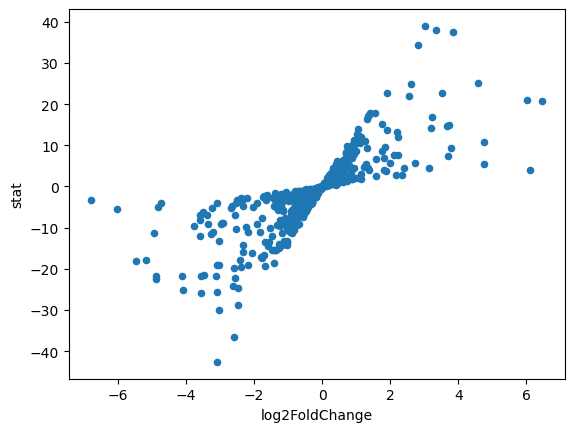

In [53]:
df_de_receptors = results_df.loc[results_df.index.intersection(unique_receptors)]
df_de_receptors = df_de_receptors.sort_values(by="stat", ascending=False)
df_de_receptors.plot.scatter(x="log2FoldChange", y="stat")

In [56]:
# We will take the top 20 receptors that increased the expression after treatment
df_top_receptors = df_de_receptors.head(20)
df_top_receptors

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
CDH6,28262.296983,3.019806,0.077417,39.007075,0.000000e+00,0.000000e+00
CRLF1,7919.672343,3.341644,0.087997,37.974317,0.000000e+00,0.000000e+00
FZD8,2719.781498,3.843015,0.102696,37.421427,1.751855e-306,1.817595e-303
CDH2,7111.507547,2.809461,0.081929,34.291273,1.058818e-257,6.138964e-255
DYSF,441.449511,4.593250,0.182207,25.208911,3.198723e-140,5.680759e-138
INHBA,24329.359641,2.598613,0.104321,24.909787,5.828479e-137,9.655193e-135
CELSR1,492.324435,3.517315,0.154495,22.766506,9.849205e-115,1.303070e-112
PDGFC,5481.167075,1.894857,0.083811,22.608707,3.558087e-113,4.676039e-111
VDR,1450.304353,2.555007,0.116782,21.878467,4.166147e-106,4.977410e-104


## Inferring intracellular signalling network with CARNIVAL and CORNETO

CORNETO is a unified framework for knowledge-driven network inference. It includes a very flexible implementation of CARNIVAL that expands its original capabilities. We will see how to use it under different assumptions to extract a network from a prior knowledge network and a set of potential receptors + our estimated TFs


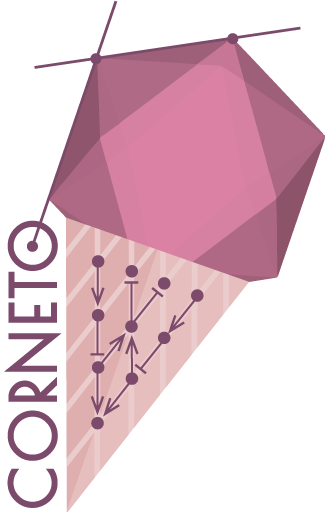

In [57]:
cn.info()

In [58]:
# We get only interactions from SIGNOR http://signor.uniroma2.it/
pkn = op.interactions.OmniPath.get(databases=['SIGNOR'], genesymbols=True)
pkn = pkn[pkn.consensus_direction==True]
pkn.head()

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,Q13976,Q13507,PRKG1,TRPC3,True,False,True,True,False,True,9,HPRD:14983059;KEA:14983059;ProtMapper:14983059...,HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...,15,8,2,14983059;16331690
1,Q13976,Q9HCX4,PRKG1,TRPC7,True,True,False,True,True,False,3,SIGNOR:21402151;TRIP:21402151;iPTMnet:21402151,SIGNOR;TRIP;iPTMnet,3,3,1,21402151
2,Q13438,Q9HBA0,OS9,TRPV4,True,True,True,True,True,True,3,HPRD:17932042;SIGNOR:17932042;TRIP:17932042,HPRD;SIGNOR;TRIP,3,3,1,17932042
3,P18031,Q9H1D0,PTPN1,TRPV6,True,False,True,True,False,True,11,DEPOD:15894168;DEPOD:17197020;HPRD:15894168;In...,DEPOD;HPRD;IntAct;Lit-BM-17;SIGNOR;SPIKE_LC;TRIP,7,6,2,15894168;17197020
4,P63244,Q9BX84,RACK1,TRPM6,True,False,True,True,False,True,2,SIGNOR:18258429;TRIP:18258429,SIGNOR;TRIP,2,2,1,18258429


In [59]:
pkn["interaction"] = pkn["is_stimulation"].astype(int) - pkn["is_inhibition"].astype(int)
sel_pkn = pkn[["source_genesymbol", "interaction", "target_genesymbol"]]
sel_pkn

,source_genesymbol,interaction,target_genesymbol
0,PRKG1,-1,TRPC3
1,PRKG1,1,TRPC7
2,OS9,0,TRPV4
3,PTPN1,-1,TRPV6
4,RACK1,-1,TRPM6
...,...,...,...
61579,DTNBP1,1,WASF2
61580,CDK1,1,KMT5A
61581,PIM2,1,CDKN1A
61582,AKT1,1,WNK1


In [60]:
# We create the CORNETO graph by importing the edges and interaction
G = cn.Graph.from_sif_tuples([(r[0], r[1], r[2]) for _, r in sel_pkn.iterrows() if r[1] != 0])
G.shape

(5436, 60020)

In [61]:
# As measurements, we take the estimated TFs, we will filter out TFs with p-val > 0.001
significant_tfs = tf_acts[tf_pvals <= 0.001].T.dropna().sort_values(by="treatment.vs.control", ascending=False)
significant_tfs

,treatment.vs.control
SRF,7.421123
MYOCD,7.372481
SMAD3,7.190940
BTG2,6.206934
TCF21,6.183177
...,...
SPI1,-5.427345
NR4A3,-5.749818
HIF3A,-5.882730
NR1H4,-6.081834


In [62]:
# We keep only the ones in the PKN graph
measurements = significant_tfs.loc[significant_tfs.index.intersection(G.V)].to_dict()["treatment.vs.control"]
measurements

{'SRF': 7.4211225509643555,
 'MYOCD': 7.372481346130371,
 'SMAD3': 7.190939903259277,
 'BTG2': 6.206934452056885,
 'SMAD2': 5.634183883666992,
 'JUNB': 5.632753849029541,
 'HMGA2': 4.937854766845703,
 'POU3F1': 4.921204090118408,
 'RORA': 4.765202045440674,
 'SMAD4': 4.588079452514648,
 'MEF2A': 4.287934303283691,
 'FOSL1': 3.938856363296509,
 'SOX4': 3.9252400398254395,
 'NCOA1': 3.8250725269317627,
 'SFPQ': 3.7440223693847656,
 'FOSB': 3.7315196990966797,
 'SP7': 3.6977312564849854,
 'HBP1': 3.6794629096984863,
 'CREB3': 3.632990837097168,
 'ASXL1': 3.574924945831299,
 'MEIS2': 3.4930355548858643,
 'TAL1': 3.354771852493286,
 'HOXC8': 3.347809314727783,
 'DLX5': 3.3378002643585205,
 'DLX2': -3.2941677570343018,
 'CDX2': -3.2988994121551514,
 'MAFA': -3.310776472091675,
 'STAT5A': -3.430389165878296,
 'RXRB': -3.4593443870544434,
 'MSX2': -3.5386831760406494,
 'SMAD6': -3.5516138076782227,
 'CEBPA': -3.59158992767334,
 'PLAGL1': -3.6208605766296387,
 'RELA': -3.63592267036438,
 'TP53'

In [64]:
# We will infer the direction, so for the inputs, we use a value of 0 (=unknown direction)
inputs = {k: 0 for k in df_top_receptors.index.intersection(G.V).values}
inputs

{'CDH6': 0,
 'CRLF1': 0,
 'FZD8': 0,
 'CDH2': 0,
 'INHBA': 0,
 'VDR': 0,
 'IGF1': 0,
 'EFNB2': 0,
 'ITGB3': 0,
 'TGFB1': 0,
 'IL21R': 0,
 'EGF': 0,
 'ITGA11': 0}

In [65]:
# We prune the network from inputs (receptors) to TFs to improve the performance.
# The pruning step removes only parts of the network that cannot be reached from the pre-selected receptors
from corneto.methods.carnival import preprocess_graph
Gp, inputs_p, measurements_p = preprocess_graph(G, inputs, measurements)
Gp.shape

(958, 3279)

In [66]:
vertices = Gp.V

In [75]:
from corneto.methods.carnival import milp_carnival

# We create a CARNIVAL problem
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0.2)

# The CARNIVAL problem contains useful variables that we will estimate from the data 
P.expr

{'vertex_inhibited': Variable((958,), vertex_inhibited, boolean=True),
 'edge_activating': Variable((3279,), edge_activating, boolean=True),
 'edge_inhibiting': Variable((3279,), edge_inhibiting, boolean=True),
 'vertex_activated': Variable((958,), vertex_activated, boolean=True),
 'vertex_position': Variable((958,), vertex_position),
 'vertex_values': Expression(AFFINE, UNKNOWN, (958,)),
 'edge_values': Expression(AFFINE, UNKNOWN, (3279,))}

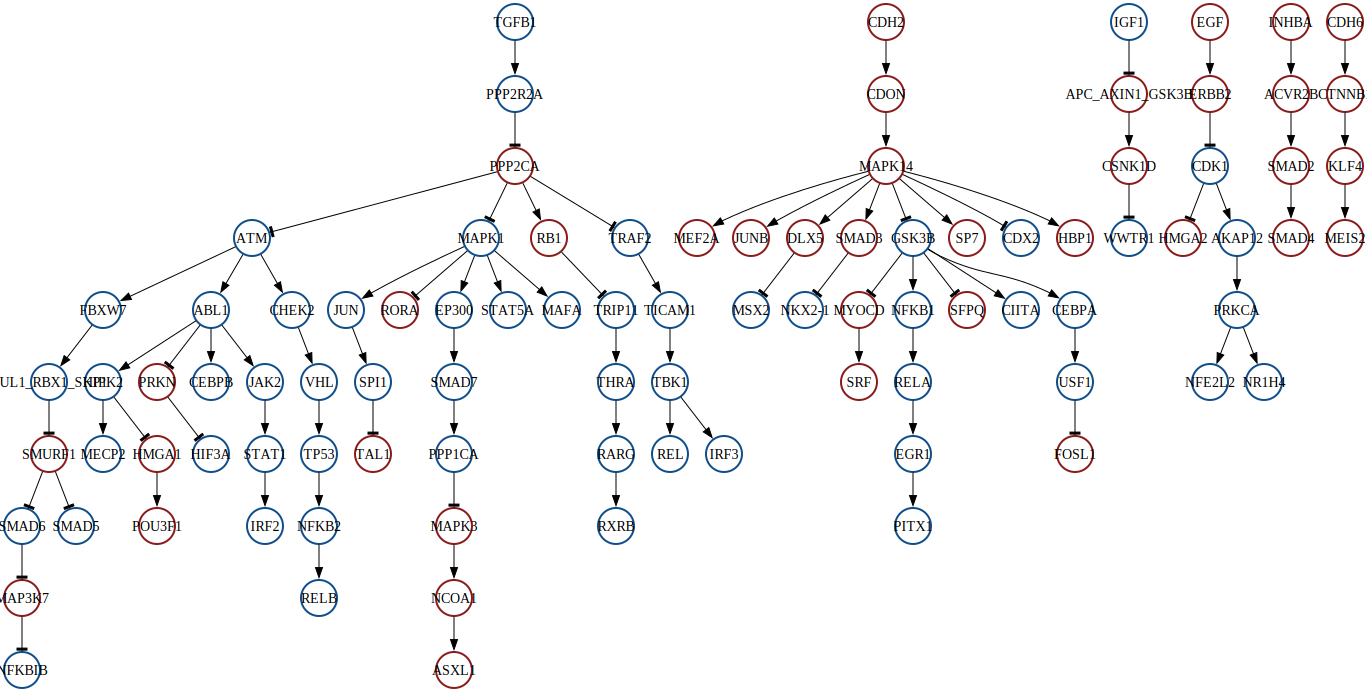

In [76]:
# We first run CARNIVAL using all selected receptors.
# We find the value for the variables using the solver GUROBI
# (needs to be installed with a valid license, academic licenses are free)
# TimeLimit and Seed are GUROBI specific parameters
P.solve(solver="GUROBI", Seed=seed);

# We extract the selected edges
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))

# We plot generating custom drawing attributes
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(G_sol.V,  vertex_sol_values))

In [77]:
# Print the values of the objectives:
# - First objective is error (non-fited TFs). 
# - Second objective is number of interactions
for o in P.objectives:
    print(o.value)

10.373496770858765
88.0


In [78]:
# The CARNIVAL problem can be manipulated for hypothesis exploration.
# For example, we will say that only 1 of the provided receptors has to be selected, at most.
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0.2)
idx_receptors = [vertices.index(k) for k in inputs_p.keys()]
protein_selected = P.expr.vertex_activated + P.expr.vertex_inhibited
P += sum(protein_selected[idx_receptors]) == 1
P.solve(solver="GUROBI", TimeLimit=max_time, Seed=seed);

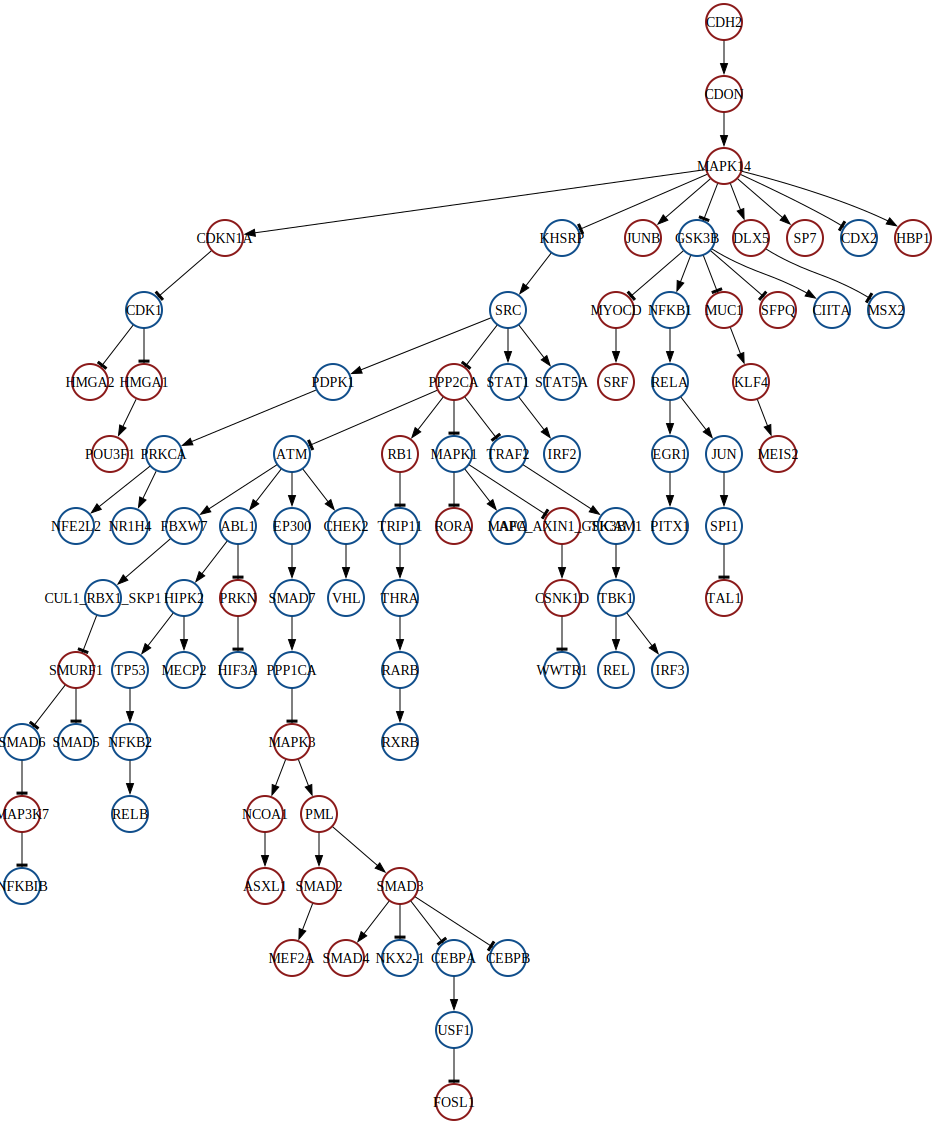

In [79]:
# We extract the edges that have some signal (edge_values != 0)
# We select the sub-graph from the processed PKN
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))

# We plot generating custom drawing attributes
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(G_sol.V,  vertex_sol_values))

In [80]:
# Print the values of the objectives:
# - First objective is error (non-fited TFs). 
# - Second objective is number of interactions
for o in P.objectives:
    print(o.value)

10.373496770858765
88.0


## Adding more knowledge

We can add more prior knowledge to the CARNIVAL problem. For example, we are going to penalise genes that are lowly abundant, according to the average basal gene expression levels. 

In [101]:
df_lowly_abundant_genes = results_df[(results_df.baseMean <= results_df.baseMean.quantile(0.25)) & (results_df.padj >= 0.05)]
df_lowly_abundant_genes.sort_values(by="padj")

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
GeneName,,,,,,
TRIM17,53.443434,-0.689125,0.300338,-2.294499,0.021762,0.050210
NLGN3,32.581601,-0.895798,0.390573,-2.293545,0.021817,0.050307
RP11-1109F11.3,11.672715,-1.587070,0.692036,-2.293336,0.021829,0.050323
RP11-661A12.5,15.285895,-1.297808,0.566496,-2.290938,0.021967,0.050602
RP11-77K12.7,25.489581,-0.991542,0.432922,-2.290350,0.022001,0.050661
...,...,...,...,...,...,...
GDPD1,74.892252,0.000326,0.262746,0.001241,0.999010,0.999415
RP11-452K12.7,49.986985,-0.000259,0.302890,-0.000855,0.999317,0.999520
MIR6859-1,10.114621,0.000625,0.657581,0.000950,0.999242,0.999520


In [103]:
lowly_abundant_genes = set(Gp.V).intersection(df_lowly_abundant_genes.index.tolist())
lowly_abundant_genes, len(lowly_abundant_genes)

({'CARD11',
  'DCC',
  'DLX2',
  'ERBB3',
  'FERMT3',
  'GHR',
  'HOXC8',
  'INPP5D',
  'ITGB4',
  'MAF',
  'MSX1',
  'NOXO1',
  'PARD6A',
  'PLEKHG6',
  'PSTPIP1',
  'PTPN22',
  'RPS6KA5',
  'TEC',
  'TIAM1'},
 19)

In [104]:
# Now we will add a penalty to avoid selecting lowly expressed genes
vertices = Gp.V
penalties = np.zeros(Gp.num_vertices)
penalties[[vertices.index(v) for v in lowly_abundant_genes.intersection(vertices)]] = 0.01
penalties

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.

In [105]:
# Create the carnival problem
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0.2)

# We penalize the inclusion of lowly expressed genes:
# protein_selected is just the sum of the binary variables vertex activated and vertex inhibited, defined in carnival.
# these variables are mutually exclusive, so the sum is at most 1, meaning that the vertex was selected, either activated (+1) or inhibited (-1)
protein_selected = P.expr.vertex_activated + P.expr.vertex_inhibited

# We multiply the vector variable of selected proteins and the penalties to
# sum the total cost: sum (v1 * penalty1 + v2 * penalty2, + v3 ...) and we add this as an objective
penalty_vertices = protein_selected @ penalties 
P.add_objectives(penalty_vertices)

# Select only 1 receptor
protein_selected = P.expr.vertex_activated + P.expr.vertex_inhibited
#P += sum(protein_selected[idx_receptors]) == 1

P.solve(solver="GUROBI", Seed=seed, TimeLimit=max_time);

C:\Users\pablo\miniconda3\envs\corneto-dev-mini\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


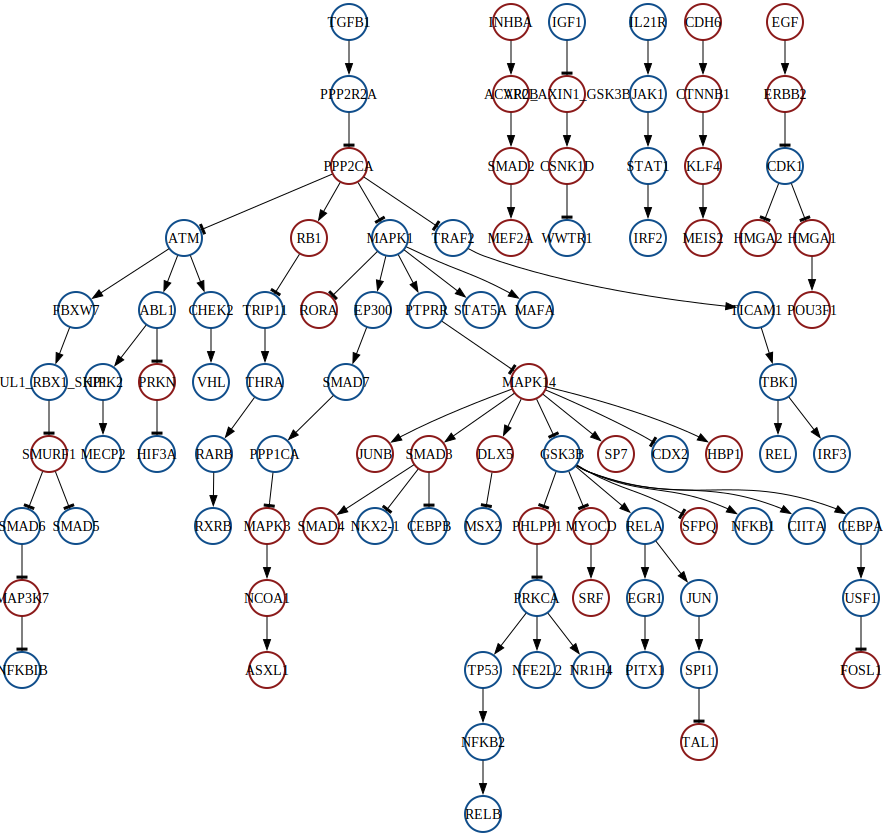

In [106]:
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(G_sol.V,  vertex_sol_values))

In [107]:
# Print the values of the objectives:
for o in P.objectives:
    print(o.value)

10.373496770858765
88.0
0.0


In [108]:
# Now we are going to force that only TGFB1 (active)
Gp, inputs_p, measurements_p = preprocess_graph(G, {"TGFB1": 1}, measurements)
Gp.shape

(949, 3261)

In [109]:
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0.2)
P.solve(solver="GUROBI", Seed=seed, TimeLimit=max_time);

In [110]:
# Same error but +2 edges were included to explain the TFs
for o in P.objectives:
    print(o.value)

10.373496770858765
90.0


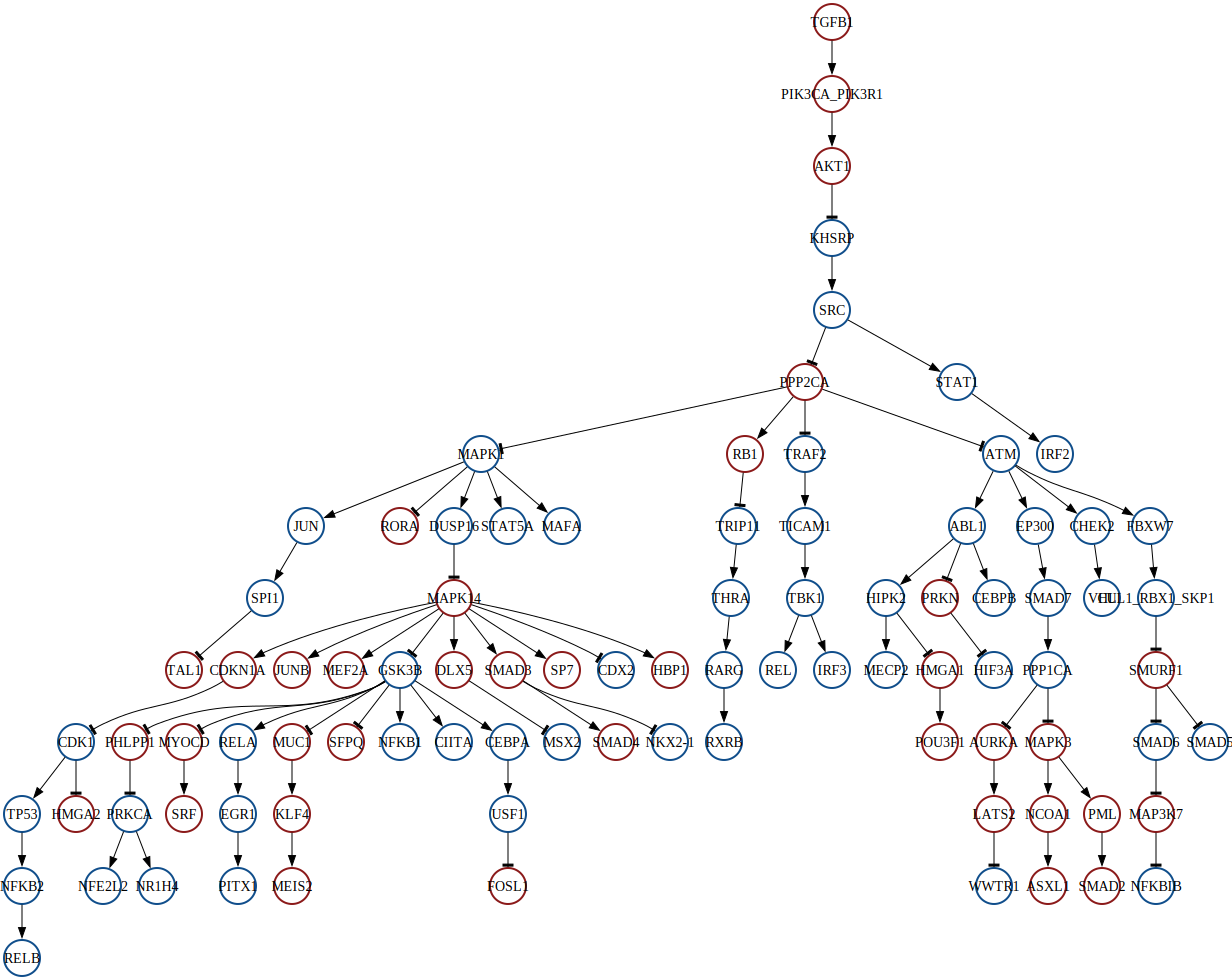

In [111]:
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(G_sol.V,  vertex_sol_values))

In [112]:
# Biasing the networks towards activatory interactions

# Create the carnival problem with Beta = 0 (to not equally penalise all interactions)
#Gp, inputs_p, measurements_p = preprocess_graph(G, {"TGFB1": 0}, measurements)
Gp, inputs_p, measurements_p = preprocess_graph(G, inputs, measurements)
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0)

# Bias towards activations, by penalizing only inhibitions
P.add_objectives(P.expr.edge_inhibiting.sum(), weights=0.2)

# Much smaller penalty for activations, since we only want to penalise them
# slightly to avoid having spurious interactions. However, inhibitions are
# penalised 20x more than activations (weight 0.2 vs 0.01)
P.add_objectives(P.expr.edge_activating.sum(), weights=0.01)

P.solve(solver="GUROBI", TimeLimit=max_time, Seed=seed);

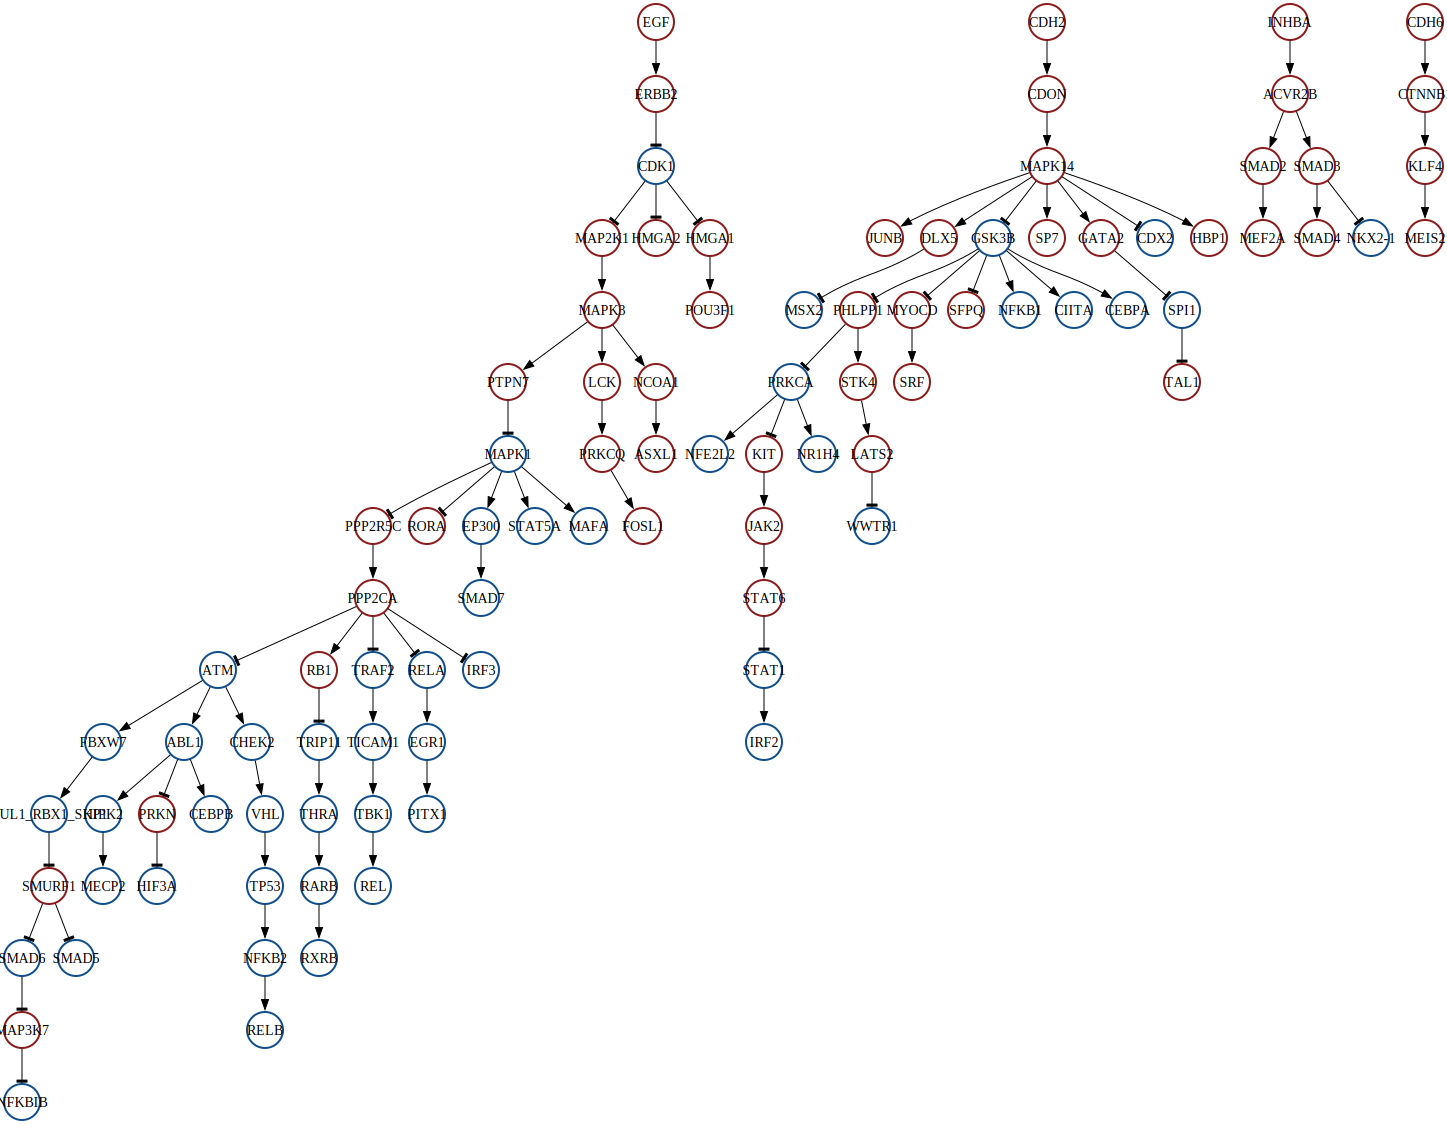

In [113]:
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(G_sol.V,  vertex_sol_values))

In [114]:
# 48 inhibitory interactions and 44 activations
for o in P.objectives:
    print(o.value)

10.373496770858765
48.0
44.0


We have explored different approaches and assumptions to recover a signalling network from TF activities and a list of potential receptors. Although changes in gene expression for signalling proteins are not always predictive of signalling cascades—hence the use of CARNIVAL as a footprint-based method to bridge the gaps between receptors and TFs—we can introduce a slight bias in the network towards signalling proteins whose gene expression has changed significantly after treatment. These changes, while indirect, may still provide valuable cues. In a manner similar to how we penalised low-abundance genes, we will now prioritize the inclusion of upregulated genes.

In [139]:
tf_acts.columns

Index(['ABL1', 'AHR', 'AIRE', 'AP1', 'APEX1', 'AR', 'ARID1A', 'ARID3A',
       'ARID3B', 'ARID4A',
       ...
       'ZNF362', 'ZNF382', 'ZNF384', 'ZNF395', 'ZNF436', 'ZNF699', 'ZNF76',
       'ZNF804A', 'ZNF91', 'ZXDC'],
      dtype='object', length=655)

In [140]:
# Since the problem minimises error, we change sign. Upregulated genes get negative score
# so if they are selected, the error decreases. The opposite for downregulated genes
df_gene_scores = (-results_df.loc[results_df.index.intersection(Gp.V).difference(tf_acts.columns)].stat)
dict_scores = df_gene_scores.to_dict()

df_gene_scores.sort_values()

NUAK1      -40.581591
CDH6       -39.007075
FZD8       -37.421427
CDH2       -34.291273
STK38L     -30.552887
              ...    
IL6R        21.833188
MAP3K5      21.883284
CASP1       23.060970
IL1R1       24.058471
TNFRSF1B    25.812839
Name: stat, Length: 627, dtype: float64

In [141]:
# Now we will add a penalty to avoid selecting lowly expressed genes
vertices = Gp.V
scores = np.array([dict_scores.get(v,0) for v in vertices])
np.sum(np.abs(scores))

3045.9775260752576

In [142]:
# Create the carnival problem
P = milp_carnival(Gp, inputs_p, measurements_p, beta_weight=0.2)
vertex_selected = P.expr.vertex_activated + P.expr.vertex_inhibited
total_score = vertex_selected @ scores 
P.add_objectives(total_score, weights=1e-3)
P.solve(solver="GUROBI", Seed=seed, TimeLimit=max_time);

C:\Users\pablo\miniconda3\envs\corneto-dev-mini\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


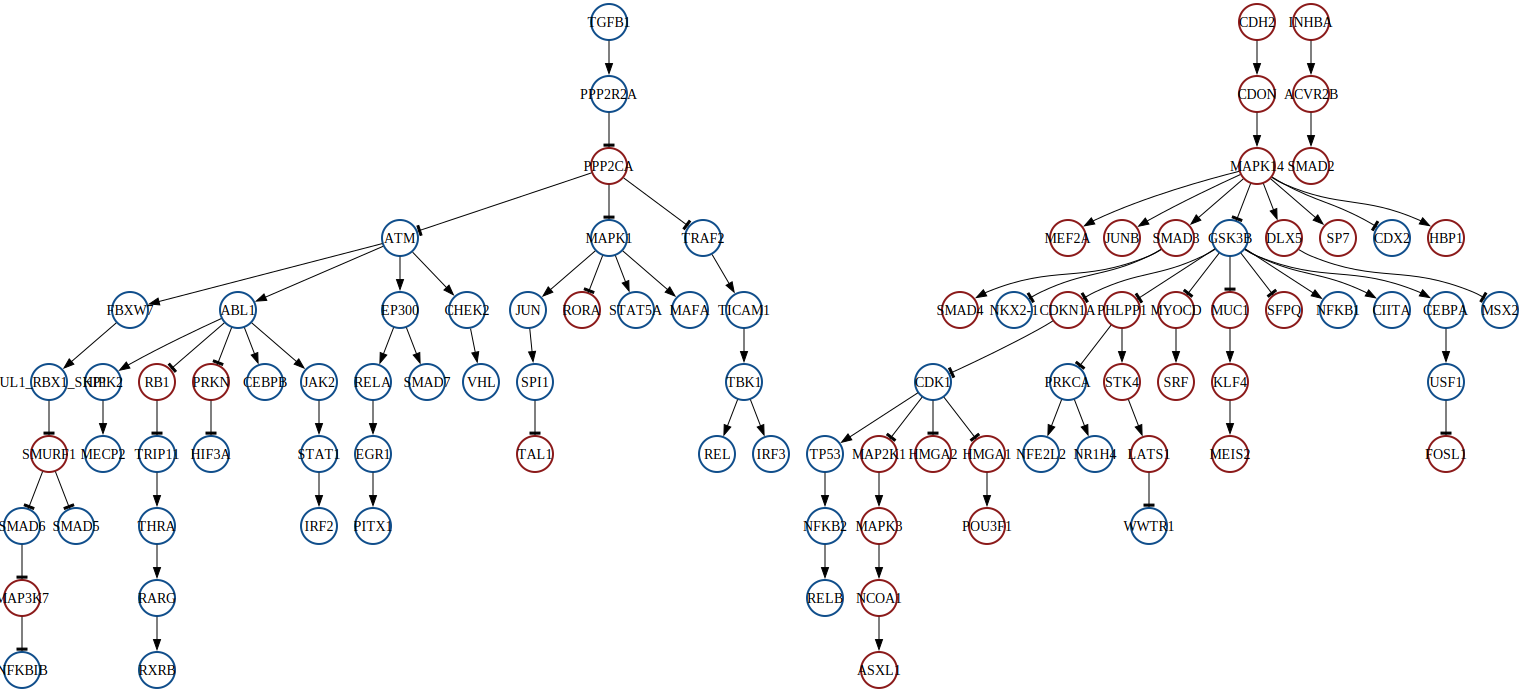

In [143]:
G_sol = Gp.edge_subgraph(np.flatnonzero(P.expr.edge_values.value))
values = P.expr.vertex_values.value
vertex_values = {v: values[i] for i, v in enumerate(Gp.V)}
vertex_sol_values = [vertex_values[v] for v in G_sol.V]
G_sol.plot(custom_vertex_attr=cn.pl.create_graphviz_vertex_attributes(G_sol.V,  vertex_sol_values))

In [144]:
for o in P.objectives:
    print(o.value)

10.373496770858765
88.0
-245.81810302737185
